In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [ ]:
!kaggle datasets download -d nirmalsankalana/sugarcane-leaf-disease-dataset

 93% 148M/160M [00:01<00:00, 181MB/s]
100% 160M/160M [00:01<00:00, 150MB/s]


In [ ]:
import zipfile
import os
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image,  ImageTk
from sklearn.model_selection import train_test_split
from pathlib import Path


In [ ]:
import zipfile
import os

zip_file = "/content/sugarcane-leaf-disease-dataset.zip"
extract_folder = "extracted_folder"

# Create a ZipFile object
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    # Extract all the contents of zip file in the specified directory
    zip_ref.extractall(extract_folder)

print("Zip file extracted successfully!")



Zip file extracted successfully!


In [ ]:
import os
import glob
import shutil
import random

def get_files(directory):
    if not os.path.exists(directory):
        return 0
    count = 0
    # crawls inside folders
    for current_path, dirs, files in os.walk(directory):
        for dr in dirs:
            count += len(glob.glob(os.path.join(current_path, dr + "/*")))
    return count

def split_dataset(source_dir, train_dir, test_dir, val_dir, split_ratio=(0.6, 0.2, 0.2)):
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)

    # Get list of classes
    classes = os.listdir(source_dir)

    for class_name in classes:
        class_source_dir = os.path.join(source_dir, class_name)
        class_train_dir = os.path.join(train_dir, class_name)
        class_test_dir = os.path.join(test_dir, class_name)
        class_val_dir = os.path.join(val_dir, class_name)

        if not os.path.exists(class_train_dir):
            os.makedirs(class_train_dir)
        if not os.path.exists(class_test_dir):
            os.makedirs(class_test_dir)
        if not os.path.exists(class_val_dir):
            os.makedirs(class_val_dir)

        files = os.listdir(class_source_dir)
        random.shuffle(files)

        num_files = len(files)
        num_train = int(num_files * split_ratio[0])
        num_test = int(num_files * split_ratio[1])
        num_val = num_files - num_train - num_test

        train_files = files[:num_train]
        test_files = files[num_train:num_train+num_test]
        val_files = files[num_train+num_test:]

        for file in train_files:
            src = os.path.join(class_source_dir, file)
            dst = os.path.join(class_train_dir, file)
            shutil.copy(src, dst)

        for file in test_files:
            src = os.path.join(class_source_dir, file)
            dst = os.path.join(class_test_dir, file)
            shutil.copy(src, dst)

        for file in val_files:
            src = os.path.join(class_source_dir, file)
            dst = os.path.join(class_val_dir, file)
            shutil.copy(src, dst)

source_dir = "/content/extracted_folder"
train_dir = "/content/train"
test_dir = "/content/test"
val_dir = "/content/val"

split_dataset(source_dir, train_dir, test_dir, val_dir)


In [ ]:
# Train file image count
train_samples = get_files(train_dir)
# Validation file image count
val_samples = get_files(val_dir)
# Test file image count
test_samples = get_files(test_dir)
# To get tags
num_classes = len(glob.glob(os.path.join(train_dir, "*")))

print(num_classes, "Classes")
print(train_samples, "Train images")
print(val_samples, "Validation images")
print(test_samples, "Test images")

5 Classes
1511 Train images
508 Validation images
502 Test images


Found 1511 images belonging to 5 classes.
Found 508 images belonging to 5 classes.
Found 502 images belonging to 5 classes.
Epoch 1/50
95/95 [==============================] - 36s 302ms/step - loss: 5.3522 - accuracy: 0.3144 - val_loss: 4.7586 - val_accuracy: 0.2087
Epoch 2/50
95/95 [==============================] - 28s 299ms/step - loss: 1.5425 - accuracy: 0.4474 - val_loss: 1.9641 - val_accuracy: 0.2382
Epoch 3/50
95/95 [==============================] - 28s 297ms/step - loss: 1.3091 - accuracy: 0.5103 - val_loss: 1.3577 - val_accuracy: 0.4114
Epoch 4/50
95/95 [==============================] - 28s 295ms/step - loss: 1.2383 - accuracy: 0.5500 - val_loss: 1.9058 - val_accuracy: 0.2598
Epoch 5/50
95/95 [==============================] - 28s 296ms/step - loss: 1.2440 - accuracy: 0.5242 - val_loss: 5.1375 - val_accuracy: 0.2776
Epoch 6/50
32/32 [==============================] - 4s 108ms/step - loss: 1.3224 - accuracy: 0.4343
Test accuracy: 0.4342629611492157
32/32 [====================

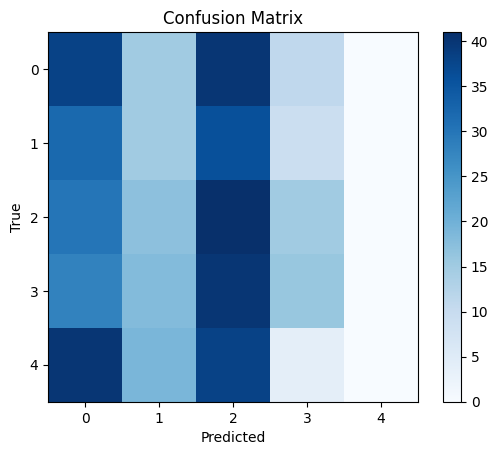

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Define directories and parameters
train_dir = '/content/train'
validation_dir = '/content/val'
test_dir = '/content/test'
img_height, img_width = 227, 227  # AlexNet requires input size to be 227x227
batch_size = 16
epochs = 50

# Define data generators
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Construct AlexNet model
def alexnet(input_shape, num_classes):
    model = models.Sequential()
    # Layer 1
    model.add(layers.Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(layers.BatchNormalization())
    # Layer 2
    model.add(layers.Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(layers.BatchNormalization())
    # Layer 3
    model.add(layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
    # Layer 4
    model.add(layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
    # Layer 5
    model.add(layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(layers.BatchNormalization())
    # Flatten
    model.add(layers.Flatten())
    # Fully connected layers
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

# Create AlexNet model
model = alexnet(input_shape=(img_height, img_width, 3), num_classes=train_generator.num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Plot confusion matrix
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

cm = confusion_matrix(true_classes, predicted_classes)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels for the test data
true_classes = []
num_batches = len(test_generator)
for i in range(num_batches):
    _, batch_true_classes = test_generator[i]
    true_classes.extend(batch_true_classes.argmax(axis=1))

# Make predictions
predictions = model.predict(test_generator)

# Convert predictions to numpy array
predicted_classes = np.argmax(predictions, axis=1)

# Convert true_classes to numpy array
true_classes = np.array(true_classes)

# Print classification report
print(classification_report(true_classes, predicted_classes))


32/32 [==============================] - 3s 106ms/step
              precision    recall  f1-score   support

           0       0.48      0.77      0.59       104
           1       0.43      0.39      0.41        92
           2       0.36      0.69      0.48       103
           3       0.56      0.30      0.39       102
           4       0.00      0.00      0.00       101

    accuracy                           0.43       502
   macro avg       0.37      0.43      0.37       502
weighted avg       0.37      0.43      0.37       502



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
